## Notebook 3 - Construção dos modelos preditivos

**Objetivo**: comparar o desempenho de diferentes modelos capazes de prever a inadimplência de clientes. E então usar o melhor modelo para gerar as predições para a base fornecida pela equipe Datarisk (teste.csv)

**Algoritmos testados:**:
- Modelo Base
- Regressão Logística
- Random Forest
- Tree Decision
- XGBoost
- SVC
- KNN
- Naive-Bayes

**Passos desenvolvidos neste notebook:**
- Importação da base de treino processada no notebook 2
- Construção de um modelo baseline (baseado no valor mais frequente do target)
- Construção de outros 7 modelos de classificação com treino único e comparação com o modelo base
- Seleção do melhor modelo
- Validação cruzada do melhor modelo (múltiplos treinos e testes)
- Teste de overfitting do melhor modelo
- Preparação e predição para a base teste.csv

**Conclusão:** o modelo campeão foi o Naive-Bayes com um desempenho médio de 38% para a principal métrica de interesse (revocação). A acurácia total do modelo foi 83%. As predições feitas por ele se encontram em ```"./dados/predict/teste.csv"```

---

## 1.Configurações gerais

### 1.1.Importações

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from   sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import MinMaxScaler
from   sklearn.preprocessing import StandardScaler

from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.svm import SVC
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.naive_bayes import GaussianNB
from   xgboost import XGBClassifier

from   sklearn.metrics import roc_auc_score
from   sklearn.metrics import recall_score

from   sklearn.metrics import roc_curve
from   sklearn.metrics import classification_report
from   sklearn.metrics import confusion_matrix
from   sklearn.metrics import ConfusionMatrixDisplay

import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Variáveis globais
test_size = 0.33
random_state = 42
to_rescale = False
min_max_method = False

### 1.2.Ingestão dos dados processados

In [3]:
if(to_rescale): path_file = "../dados/proc/train_to_rescale.pkl"
else: path_file = "../dados/proc/train_without_outliers.pkl"
     
with open(path_file, "rb") as f:
    train = pickle.load(f)

In [4]:
train.shape

(77509, 6)

In [5]:
train.sample(3)

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto
76679,0,0.108395,27,0.115442,2000.0,8
91490,0,0.806413,59,0.992728,8800.0,18
1014,0,0.408691,46,1.055196,4166.0,12


### 1.3.Funções auxiliares

In [6]:
def baseline_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [7]:
def show_recall_score(y_test,y_predict):
    recall = recall_score(y_test, y_predict)
    print(f"Recall score = {round(recall*100, 2)}%")
    return recall;

In [8]:
def show_confusion_matrix(y_test, y_predict, title, model=False):
    if(model): labels = model.classes_
    else: labels = [0,1]
        
    cm = confusion_matrix(y_test, y_predict, labels=labels)
    plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plot.plot()
    plt.grid(False)
    plt.title(title)
    plt.show();

In [9]:
def show_roc_report(y_test, y_predict, X_test, model=False):
    
    if(model):
        y_pred_proba = model.predict_proba(X_test)[::,1]
    else:
        y_pred_proba = y_predict
    
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    classfication_report = classification_report(y_test, y_predict)
    
    print(f"AUC  = {round(auc, 2)}")
    print(classfication_report)
    
    plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    return auc;

---

## 2.Ajustes na base de treino

### 2.1.Separação de variáveis preditoras e target

In [10]:
target_name = "inadimplente"
X = train.drop(target_name, axis=1).values
y = train[target_name]

### 2.2.Rescalonamento das variáveis preditoras

Essa será uma das abordagens possíveis. Os algoritmos preditivos serão treinandos tanto com rescalonamento dos dados quanto com os dados na escala original, para checarmos o melhor desempenho. O usuário poderá decidir quando rescalonar os dados através da variável global **"to_rescale"**:

In [11]:
if(to_rescale):
    if(min_max_method):
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X = scaler.fit_transform(X)

### 2.2.Separação da base de treino e validação

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size, 
                                                    random_state=random_state,
                                                    stratify=y
                                                   )

In [13]:
print(f'----------')
print(f'Bases de treino: {X_train.shape, y_train.shape}')
print(f'Bases de teste: {X_test.shape, y_test.shape}')

----------
Bases de treino: ((51931, 5), (51931,))
Bases de teste: ((25578, 5), (25578,))


---
## 3.Construção dos modelos preditivos

### 3.1.Métricas de desempenho avaliadas

O uso de métricas apropriadas em análises preditivas é crucial para o sucesso de um projeto de aprendizado de máquina. E escolha da métrica deve levar em conta o objetivo do modelo no mundo real e o custo de cada tipo de erro.

Para entender quais as métricas de desempenho mais interessam à natureza do nosso negócio, primeiro é importante nos situarmos em relação ao tipo de análise que estamos fazendo. Trata-se de um modelo de classificação de inadimplência. Quando pensamos nos erros de modelos preditivos de classificação, temos 2 cenários possíveis:

**1.Falsos positivos:** o modelo dirá que o cliente será inadimplente, mas ele NÃO será. O empréstimo será negado.

**2.Falsos negativos:** o modelo dirá que o cliente não será inadimplente, mas ele SERÁ. O empréstimo será concedido. Pra mim, ```este parece ser o tipo de erro que mais queremos evitar```, pois tende a causar mais prejuízos ao nosso negócio (financiadora) já que o empréstimo será liberado com riscos de inadimplência. Ao contrário do cenário 1, onde o empréstimo será negado.

Usaremos a matriz de confusão para avaliar a quantidade de erros de cada tipo de erro. E a métrica de desempenho que mais nos interessará será a ```REVOCAÇÃO```, que dá maior ênfase para os erros falsos positivos. A revocação nos ajudará a responder a seguinte pergunta: "De todos os exemplos de clientes que são inadiplentes, quantos foram classificados corretamente durante a validação do modelo?"

Por exemplo, se obtermos um valor de 0.90 de revocação, significa que a cada 100 clientes inadimplentes, 90 foram identificados corretamente como positivos, e o empréstimo foi corretamente negado.

Tb usaremos a área da curva ROC, que considera os limiares de probabilidade para a classificação de positivos. Quanto maior o valor da área, melhor o desemepnho do modelo.

Você pode encontrar uma ótima explicação das métricas de avaliação de modelos de classificação e sobre a matriz de confusão [neste artigo](https://medium.com/kunumi/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-em-machine-learning-classifica%C3%A7%C3%A3o-49340dcdb198) (Fonte: 1).

### 3.2.Modelo Base

É o modelo mais simples que eu consigo imaginar e retorna a classe mais frequente da minha variável target. Servirá para comparação com os modelos mais complexos. Entendo que a análise com esses últimos só valerá a pena se  o desempenho deles for bem melhor do que o meu modelo baseline. Se não, sempre optaremos pela simplicidade e NÃO precisaremos de modelos complexos para prever a inadimplência. Basta prever que todos os clientes não são inadimplentes (target = 0) e acertaremos cerca de 93% de todos os casos (acurácia). 

Em contrapartida, o meu modelo nunca preveria um verdadeiro positivo (inadimplência, target = 1) com sucesso, que é o caso que mais nos interessa.

In [14]:
y_hat_baseline = baseline_model(X_test)

In [15]:
zeros_count = np.unique(y_hat_baseline, return_counts=True)[1]
unique_values = np.unique(y_hat_baseline, return_counts=True)[0]
print(f"There are {int(zeros_count)} occurrences of {int(unique_values)} value in predict data.")

There are 25578 occurrences of 0 value in predict data.


Desempenho do modelo:

Recall score = 0.0%
AUC  = 0.5
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.00      0.00      0.00      1622

    accuracy                           0.94     25578
   macro avg       0.47      0.50      0.48     25578
weighted avg       0.88      0.94      0.91     25578



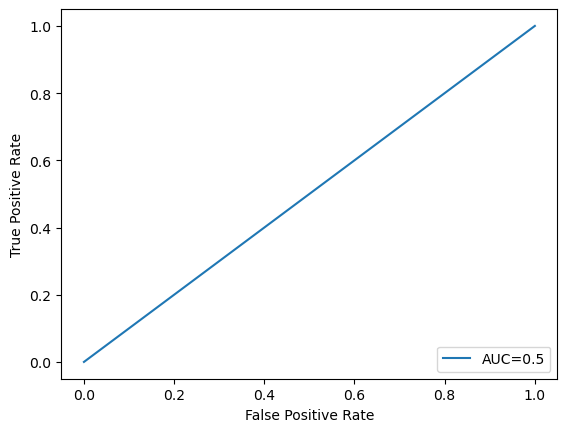

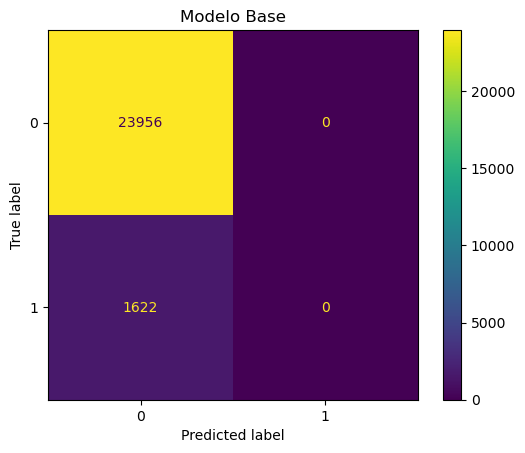

In [16]:
show_recall_score(y_test, y_hat_baseline)
show_roc_report(y_test, y_hat_baseline, X_test)
show_confusion_matrix(y_test, y_hat_baseline, "Modelo Base")

### 3.3.Regressão Logística

In [17]:
logis = LogisticRegression()
logis.fit(X_train, y_train)
y_hat_rl = logis.predict(X_test)

Recall score = 0.0%
AUC  = 0.77
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.00      0.00      0.00      1622

    accuracy                           0.94     25578
   macro avg       0.47      0.50      0.48     25578
weighted avg       0.88      0.94      0.91     25578



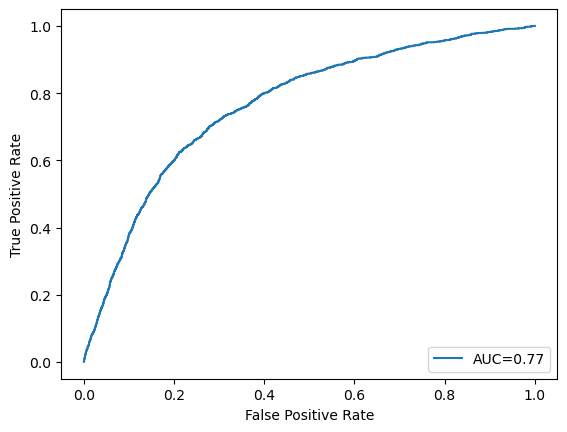

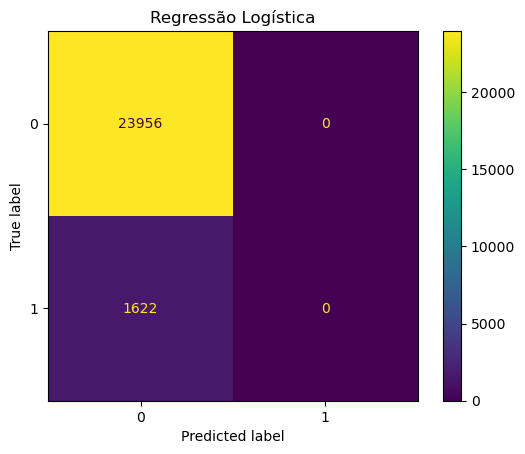

In [18]:
show_recall_score(y_test, y_hat_rl)
show_roc_report(y_test, y_hat_rl, X_test, logis)
show_confusion_matrix(y_test, y_hat_rl, "Regressão Logística", logis)

### 3.4.Random Forest

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_hat_rf = rf.predict(X_test)

Recall score = 0.92%
AUC  = 0.73
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.16      0.01      0.02      1622

    accuracy                           0.93     25578
   macro avg       0.55      0.50      0.49     25578
weighted avg       0.89      0.93      0.91     25578



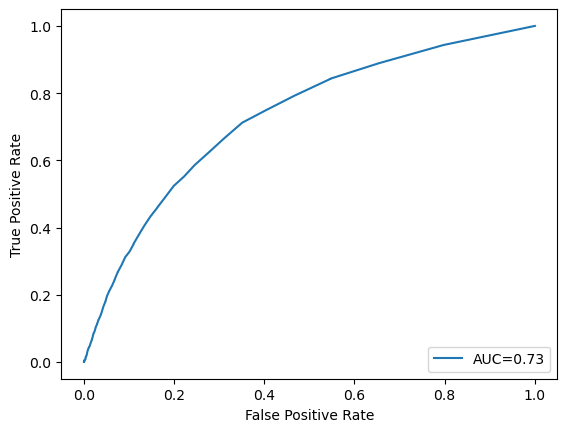

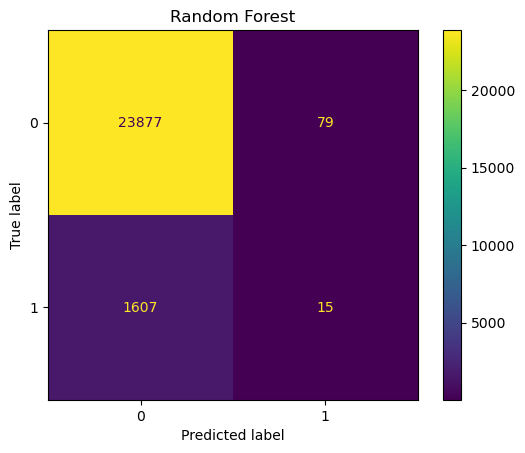

In [20]:
show_recall_score(y_test, y_hat_rf)
show_roc_report(y_test, y_hat_rf, X_test, rf)
show_confusion_matrix(y_test, y_hat_rf, "Random Forest", rf)

### 3.5.Árvore de Decisão

In [21]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_hat_dtree = dtree.predict(X_test)

Recall score = 15.04%
AUC  = 0.54
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     23956
           1       0.13      0.15      0.14      1622

    accuracy                           0.88     25578
   macro avg       0.54      0.54      0.54     25578
weighted avg       0.89      0.88      0.89     25578



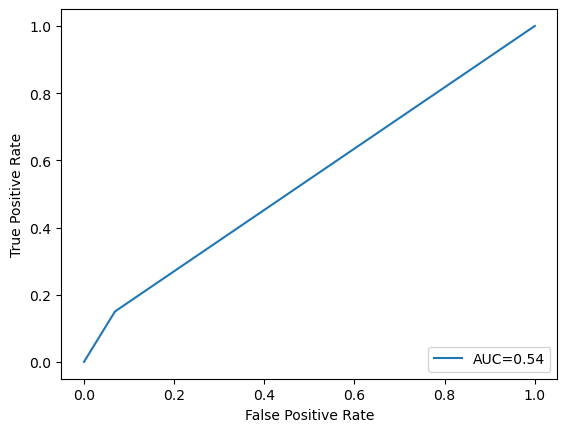

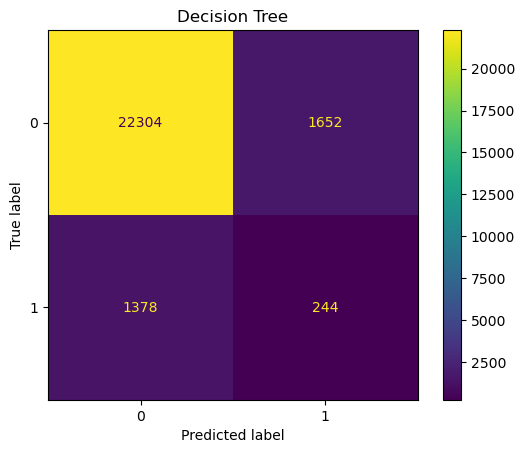

In [22]:
show_recall_score(y_test, y_hat_dtree)
show_roc_report(y_test, y_hat_dtree, X_test, dtree)
show_confusion_matrix(y_test, y_hat_dtree, "Decision Tree", dtree)

### 3.6.XGBoost

In [23]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_hat_xgb = xgb.predict(X_test)

Recall score = 0.8%
AUC  = 0.75
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.19      0.01      0.02      1622

    accuracy                           0.93     25578
   macro avg       0.56      0.50      0.49     25578
weighted avg       0.89      0.93      0.91     25578



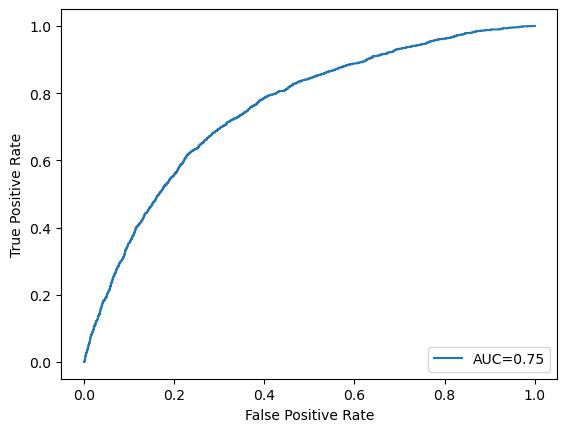

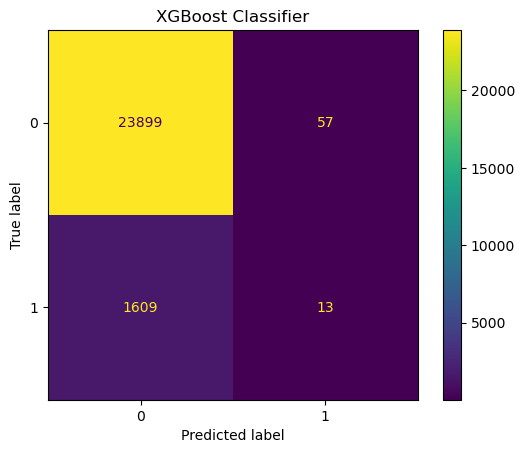

In [24]:
show_recall_score(y_test, y_hat_xgb)
show_roc_report(y_test, y_hat_xgb, X_test, xgb)
show_confusion_matrix(y_test, y_hat_xgb, "XGBoost Classifier", xgb)

### 3.7.SVC

In [25]:
svc = SVC()
svc.fit(X_train, y_train)
y_hat_svc = svc.predict(X_test)

Recall score = 0.0%
AUC  = 0.75
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.00      0.00      0.00      1622

    accuracy                           0.94     25578
   macro avg       0.47      0.50      0.48     25578
weighted avg       0.88      0.94      0.91     25578



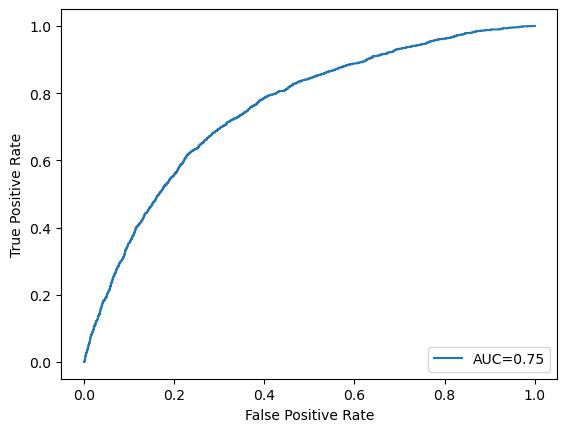

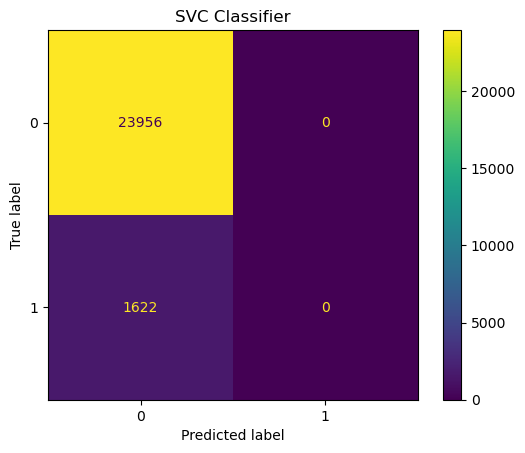

In [26]:
show_recall_score(y_test, y_hat_svc)
show_roc_report(y_test, y_hat_svc, X_test, xgb)
show_confusion_matrix(y_test, y_hat_svc, "SVC Classifier", svc)

### 3.8.KNN

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_hat_knn = knn.predict(X_test)

Recall score = 0.37%
AUC  = 0.54
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23956
           1       0.07      0.00      0.01      1622

    accuracy                           0.93     25578
   macro avg       0.50      0.50      0.49     25578
weighted avg       0.88      0.93      0.90     25578



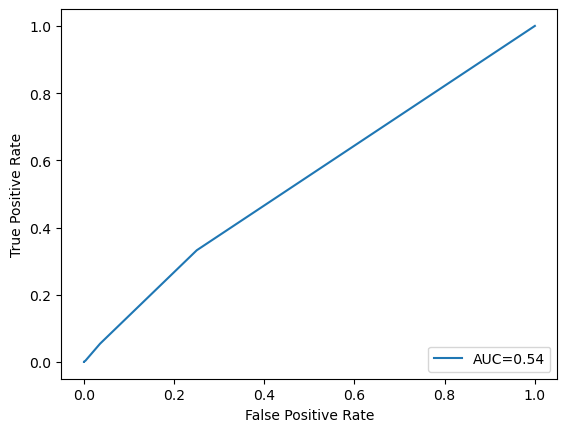

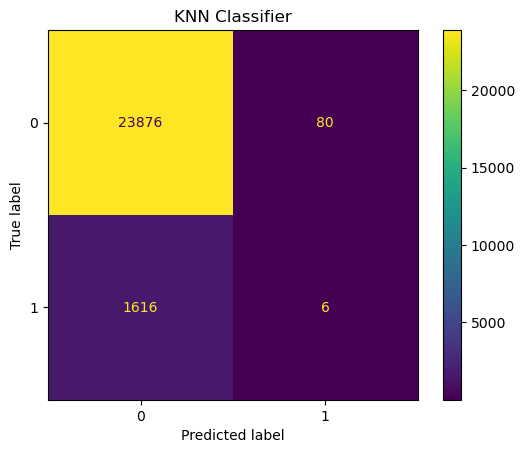

In [28]:
show_recall_score(y_test, y_hat_knn)
show_roc_report(y_test, y_hat_knn, X_test, knn)
show_confusion_matrix(y_test, y_hat_knn, "KNN Classifier", knn)

### 3.9.Naive-Bayes

In [29]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_hat_gnb = gnb.predict(X_test)

Recall score = 42.05%
AUC  = 0.75
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     23956
           1       0.20      0.42      0.27      1622

    accuracy                           0.85     25578
   macro avg       0.58      0.65      0.59     25578
weighted avg       0.91      0.85      0.88     25578



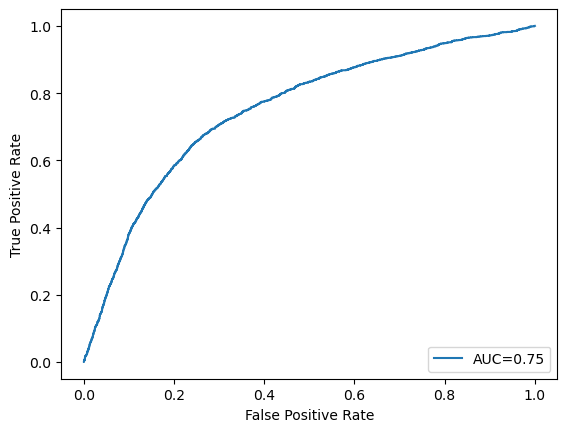

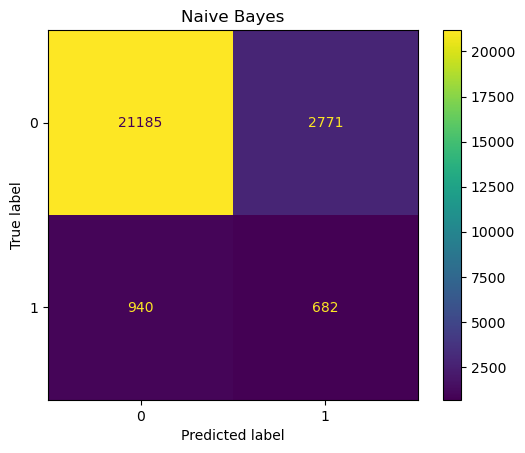

In [30]:
show_recall_score(y_test, y_hat_gnb)
show_roc_report(y_test, y_hat_gnb, X_test, gnb)
show_confusion_matrix(y_test, y_hat_gnb, "Naive Bayes", gnb)

---

## 4.Resumo da iteração com melhor resultado

Depois de tentar várias abordagens e gerar conjuntos de dados com diferentes caracteísticas, cheguei a conclusão que o Naive-Bayes é o melhor modelo quando fazemos tratamento de outliers, seleção de features e mantemos os dados em sua escala original (sem rescalonamento). Abaixo, segue um comparativo do desempenho dos modelos treinado com esses dados finais:

In [31]:
metrics_table = pd.DataFrame(
    {
    "Model": ["Baseline","Logistic Reg","Random Forest","Tree Decision","XGBoost","SVC","KNN","Naive-Bayes"],
    "%Recall": [0.0, 0.0, 0.9, 16.2, 0.8, 0.0, 0.4, 42.0],
    "%Accuracy": [94.0, 94.0, 93.0, 88.0, 93.0, 94.0, 93.0, 85.0],
    "AUC": [0.50, 0.77, 0.73, 0.55, 0.75, 0.75, 0.54, 0.75]
    }
).sort_values(ascending=False, by="%Recall")

In [32]:
metrics_table

,Model,%Recall,%Accuracy,AUC
7,Naive-Bayes,42.0,85.0,0.75
3,Tree Decision,16.2,88.0,0.55
2,Random Forest,0.9,93.0,0.73
4,XGBoost,0.8,93.0,0.75
6,KNN,0.4,93.0,0.54
0,Baseline,0.0,94.0,0.50
1,Logistic Reg,0.0,94.0,0.77
5,SVC,0.0,94.0,0.75


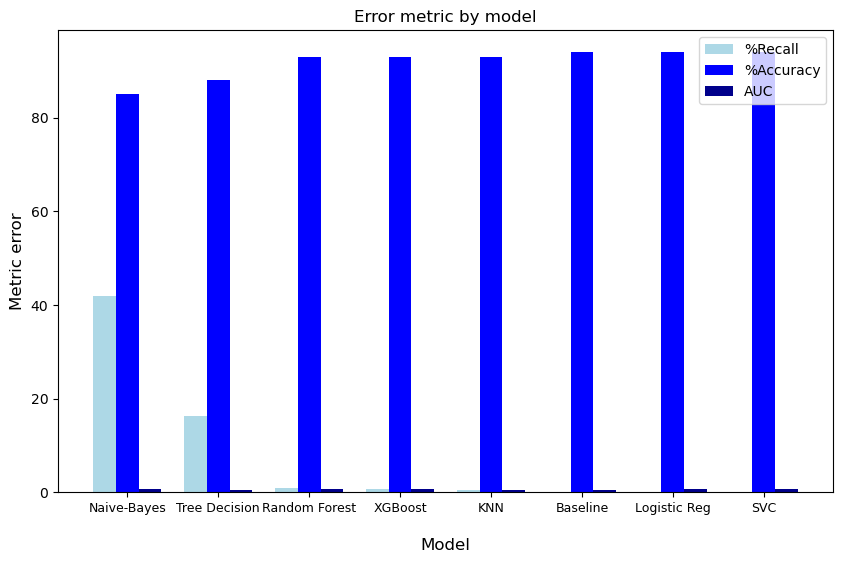

In [33]:
f, ax = plt.subplots(figsize=(10,6))

x1 = np.arange(len(metrics_table["Model"]))
x2 = [x + 0.25 for x in x1]
x3 = [x + 0.25 for x in x2]

# Plotando valores
plt.bar(x1,metrics_table["%Recall"], width=0.25, label="%Recall", color='lightblue')
plt.bar(x2,metrics_table["%Accuracy"], width=0.25, label="%Accuracy", color='blue')
plt.bar(x3,metrics_table["AUC"], width=0.25, label="AUC", color='darkblue')

plt.xticks(x2,metrics_table["Model"], fontsize=9)
plt.ylabel("Metric error", fontdict={"size": 12})
plt.xlabel("\nModel", fontdict={"size": 12})
plt.title("Error metric by model", fontdict={"size": 12})
plt.legend()
plt.show();

---
## 5.Validando o melhor modelo

### 5.1.Validação cruzada

Agora que temos um modelo candidato, é importante realizar a validação cruzada realizando múltiplos treinos do algoritmo e garantindo que estamos testando todos os registros da base. Isso ajudará a reduzir os efeitos da aleatoriedade sobre o processo de aprendizagem dos dados. Ou seja, pode ser que esse modelo tenha se saído bem simplesmente porque fizemos um teste único com registros que eram muito parecidos com aqueles usados durante o treino, e o modelo "decorou" os valores, ao invés de realmente aprender os padrões e fazer previsões de forma assertiva.

In [34]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=10, scoring='recall')
print(f"Recall: Média {round(scores.mean()*100, 2)}% (+/-{round(scores.std()*100,2)}%)")

Recall: Média 39.58% (+/-3.5%)


Vemos que a média de revogação é 39% quando realizamos 10 diferentes treinos e testes. Ou seja, os valores obtidos anteriormente são robustos e vou prosseguir com este modelo como sendo o campeão.

### 5.2.Checando ocorrência de *overfitting*

Caminhando para o final da análise, vamos fazer uma última validação do melhor modelo, avaliando se pode estar havendo sobre-ajuste aos dados de treino *(overfitting)*. Uma forma de se fazer isso é fazer previsões com o algoritmo treinado para a própria base de treino. Se o modelo se sai muito melhor nas previsões para a base de treino do que para a base de teste podemos suspeitar que temos um modelo sobre-ajustado. E que provavelmente não irá performar bem quando for colocado em produção e tiver que lidar com valores desconhecidos dos atributos. 

Vamos testar com o modelo campeão:

In [35]:
gnb_overfit_test = GaussianNB()
gnb_overfit_test.fit(X_train, y_train)
y_predict = gnb_overfit_test.predict(X_train)
show_recall_score(y_train, y_predict)

Recall score = 42.59%


0.4258809234507898

AUC  = 0.75
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     48639
           1       0.20      0.43      0.27      3292

    accuracy                           0.86     51931
   macro avg       0.58      0.66      0.60     51931
weighted avg       0.91      0.86      0.88     51931



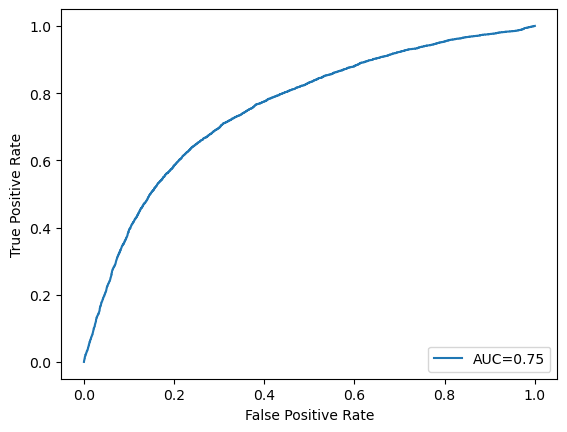

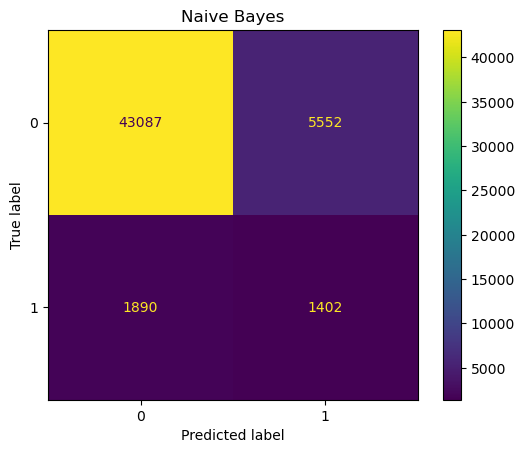

In [36]:
show_roc_report(y_train, y_predict, X_train, gnb_overfit_test)
show_confusion_matrix(y_train, y_predict, "Naive Bayes", gnb_overfit_test)

Podemos ver que o desempenho nas predições para a base de treino não foi tão superior a de teste. Portanto, nosso modelo parece adequado.

---
## 6.Gerando as predições

### 6.1.Importação e Processamento

A base de teste será processada para obter os mesmos atributos e características da base usada para treinamento do algoritmo. A base de treino foi processada no notebook 2.

In [37]:
test_raw = pd.read_csv("../dados/raw/teste.csv")
test = test_raw.copy()

In [38]:
train_columns = train.drop(target_name, axis=1).columns
test = test[train_columns]
list(train_columns) == list(test.columns)

True

In [39]:
test.isnull().sum()

util_linhas_inseguras            0
idade                            0
razao_debito                     0
salario_mensal                7968
numero_linhas_crdto_aberto       0
dtype: int64

In [40]:
mean_salary = test["salario_mensal"].mean()
test["salario_mensal"] = test["salario_mensal"].fillna(mean_salary)

In [41]:
test.isnull().sum()

util_linhas_inseguras         0
idade                         0
razao_debito                  0
salario_mensal                0
numero_linhas_crdto_aberto    0
dtype: int64

In [42]:
test.sample(3)

,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto
888,0.873127,22,0.025974,1000.000000,2
17454,0.065474,53,47.000000,6760.601836,1
39840,0.022192,83,0.301162,7314.000000,6


In [43]:
test.shape

(40000, 5)

### 6.3.Realizando e exportando as predições

In [45]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predict = gnb.predict(test.values)
test_raw["inadimplente"] = predict
test_raw.to_csv("../dados/predict/teste.csv", sep="\t", encoding='utf-8')

---
## Conclusão final

Após tentar diferentes abordagens e modelagens com os dados, o modelo campeão foi o Naive-Bayes, com um desempenho médio de 38% para a métrica de interesse (revocação). Isso quer dizer que de todos os clientes que são inadimplentes, o modelo será capaz de prever corretamente 38% deles, subsidiando a decisão de negação de empŕestimo. 

Se considerarmos outras métricas que incluem acertos do modelo para clientes adimplentes (e não só inadimplentes), o desempenho sobe para 83% total de acertos (acurácia). 

O modelo campeão também foi testado em relação à possibilidade de sobre-ajuste aos dados de treino e parece ser capaz de lidar com novos dados desconhecidos em um hipotético ambiente de produção. Ou seja, não há evidências de overfitting.

Considero que eu tenha obtido um bom modelo, capaz de ajudar o negócio a evitar prejuízos com concessão de empréstimos a clientes inadimplentes. Talvez algumas melhorias poderiam ser obtidas com algoritmos mais complexos, como redes neurais. Porém, apesar de mais eficientes, eu considero esses modelos excessivamente complexos e de difícil explicabilidade. Portanto, preferi modelar o meu fenômeno de forma mais simples, explorando todas as etapas de um problema típico de machine learning, e obtendo resultados que são mais transparentes e facilmente interpretáveis. 

O modelo campeão foi usado para fazer as predições no arquivo de teste fornecido pela equipe Datarisk. Elas se encontram em "dados/predict/teste.csv".


---
## Referências

1.Métricas de Avaliação em Machine Learning: Classificação. Disponível em: https://medium.com/kunumi/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-em-machine-learning-classifica%C3%A7%C3%A3o-49340dcdb198.